### 데이터 사전 처리(Preprocessing)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

house_df_org = pd.read_csv('house_price.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


- 데이터의 크기, 피쳐들의 타입, 결측치를 확인
- 결측치가 1000개 이상인 것들도 존재, 너무 많으면 가치가 떨어지므로 삭제

In [2]:
print('데이터 세트의 Shape: ', house_df.shape)
print('\n 전체 feature들의 type \n: ', house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series>0].sort_values(ascending = False))

데이터 세트의 Shape:  (1460, 81)

 전체 feature들의 type 
:  object     43
int64      35
float64     3
dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


- target값의 분포를 확인해 보면 왜곡정도를 살펴보면 좌측으로 치우쳐있음
- 이를 로그 변환하여 분포를 고르게 만듦

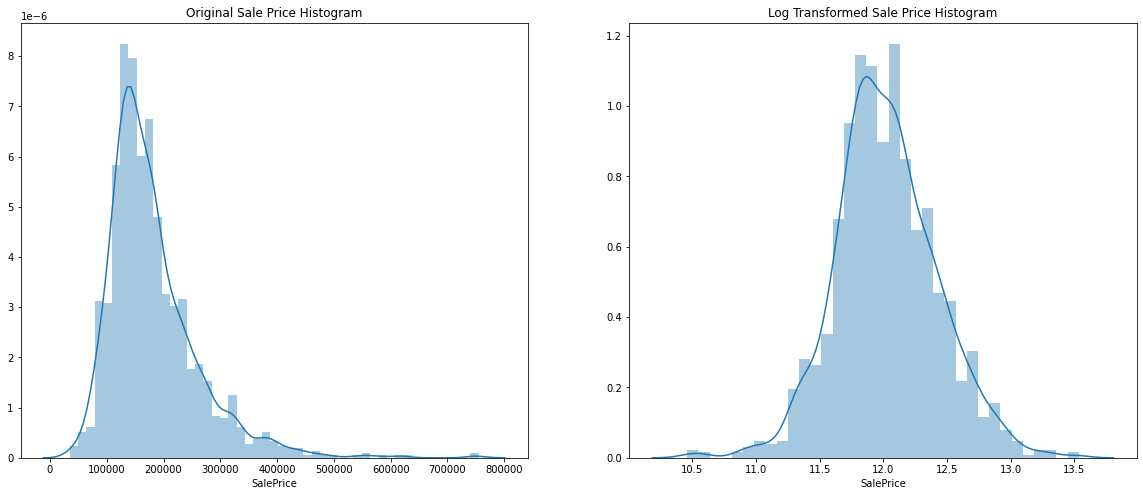

In [3]:
fig, ax = plt.subplots(1,2,figsize = (20,8))

ax[0].set_title('Original Sale Price Histogram')
sns.distplot(house_df["SalePrice"], ax = ax[0])

ax[1].set_title('Log Transformed Sale Price Histogram')
sns.distplot(np.log1p(house_df["SalePrice"]), ax = ax[1])

plt.show()

In [4]:
# SalePrice 로그변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC','MiscFeature','Alley','Fence','FireplaceQu'],axis = 1, inplace = True)

# Drop하지 않는 숫자형 Null 컬럼들은 평균값으로 대체
house_df.fillna(house_df.mean(),inplace = True)

# Null값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


문자열 피쳐에서의 Null값은 None칼럼으로 대체된다

In [5]:
print('get_dummies() 수행전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피쳐의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행전 데이터 Shape: (1460, 75)
get_dummies() 수행후 데이터 Shape: (1460, 271)
## Null 피쳐의 Type :
 Series([], dtype: object)


### 선형 회귀 모델의 학습/예측/평가

In [6]:
# 개별 모델의 rmse를 구하는 함수
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__, np.round(rmse,3)))
    return rmse

# 리스트에 있는 모델들의 rmse를 구하는 함수
def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [7]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

# 각 모델 학습
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

# 각 모델 예측/평가
models = [lr_reg,ridge_reg,lasso_reg] 
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154372, 0.12750846334053045, 0.17628250556471395]

- 다른 모델에 비해 lasso는 성능이 좋지 못함
- 모델별로 어떤 변수에 영향을 받았는지 확인하기 위해 coef를 시각화(상 하위 10개)

In [8]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성, index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개, - 하위 10개 coefficient를 추출하여 반환
    coef_high = coef.sort_values(ascending = False).head(10)
    coef_low = coef.sort_values(ascending = False).tail(10)
    return coef_high, coef_low

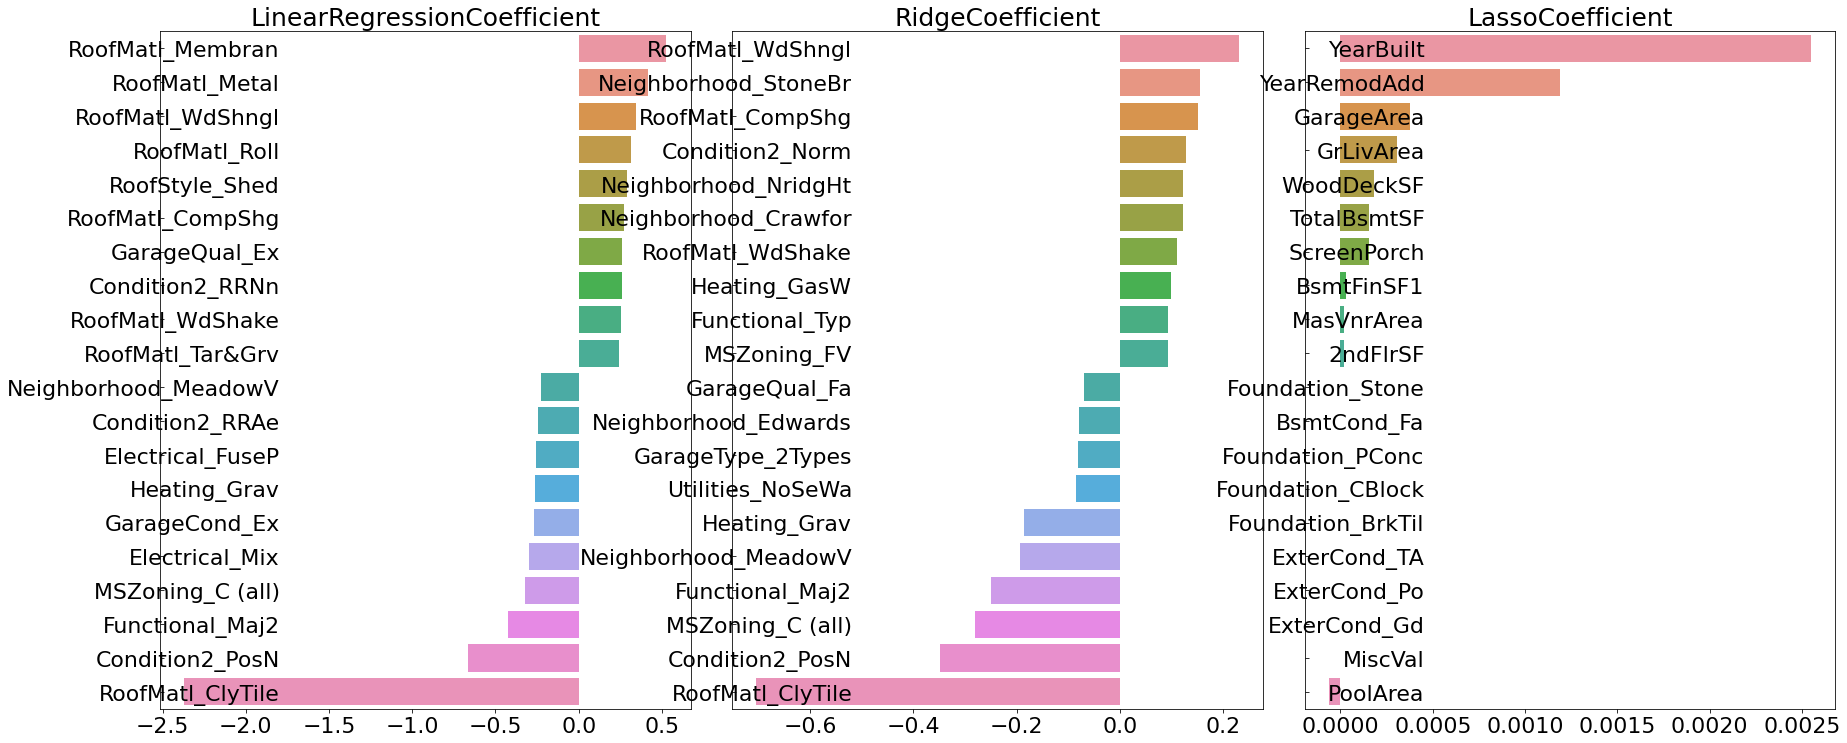

In [9]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig ,axs = plt.subplots(1,3,figsize = (24,10))
    fig.tight_layout()
    
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀계수 시각화
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        # 순차적으로 ax subplot에 batchar로 표현, 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정. 
        axs[i_num].set_title(model.__class__.__name__+'Coefficient', size = 25)
        axs[i_num].tick_params(axis = 'y', direction='in', pad = -120)
        for label in (axs[i_num].get_xticklabels()+axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i_num])

# 기존의 모델들을 불러와 회귀계수 시각화
models = [lr_reg,ridge_reg,lasso_reg]
visualize_coefficient(models)

- 회귀계수를 살펴본 결과 OLS기반의 Ridge와 LinearRegression은 비슷한 회귀 계수를 가짐을 알 수 있음
- Lasso는 성능도 떨어지면서(튜닝이 필요) 다른 두 모델과 다른 회귀계수를 가짐
- 특히 회귀계수의 값이 많이 낮게 나옴을 볼 수 있음
- validation set이 뽑히면서 영향을 줄 수 있으니 이번엔 전체데이터로 측정

In [10]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score() 수행, 
        # 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                            scoring = "neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{0} CV 평균 RMSE 값: {1}'.format(model.__class__.__name__, np.round(np.mean(rmse_list),3)))
# 앞예제에서 학습한 모델들의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV 평균 RMSE 값: 0.155

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


- 폴드 세트로 학습한 후 평가해도 라쏘는 두 모델의 성능보다 떨어짐
- 하이퍼 파라미터 튜닝을 통해 개선 시도

#### 파라미터 튜닝 후 학습/예측/평가

In [11]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                             scoring='neg_mean_squared_error', cv = 5)
    grid_model.fit(X_features,y_target)
    rmse = np.sqrt(-1 * grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                                             np.round(rmse, 4 ), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1.5,10]}

best_ridge = print_best_params(ridge_reg,ridge_params)
best_lasso = print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.142, 최적 alpha:{'alpha': 0.001}


- lasso의 성능이 ridge만큼 개선이 되었음을 확인할 수 있음
- 최적화된 파라미터(alpha)를 이용 학습/예측/평가 수행

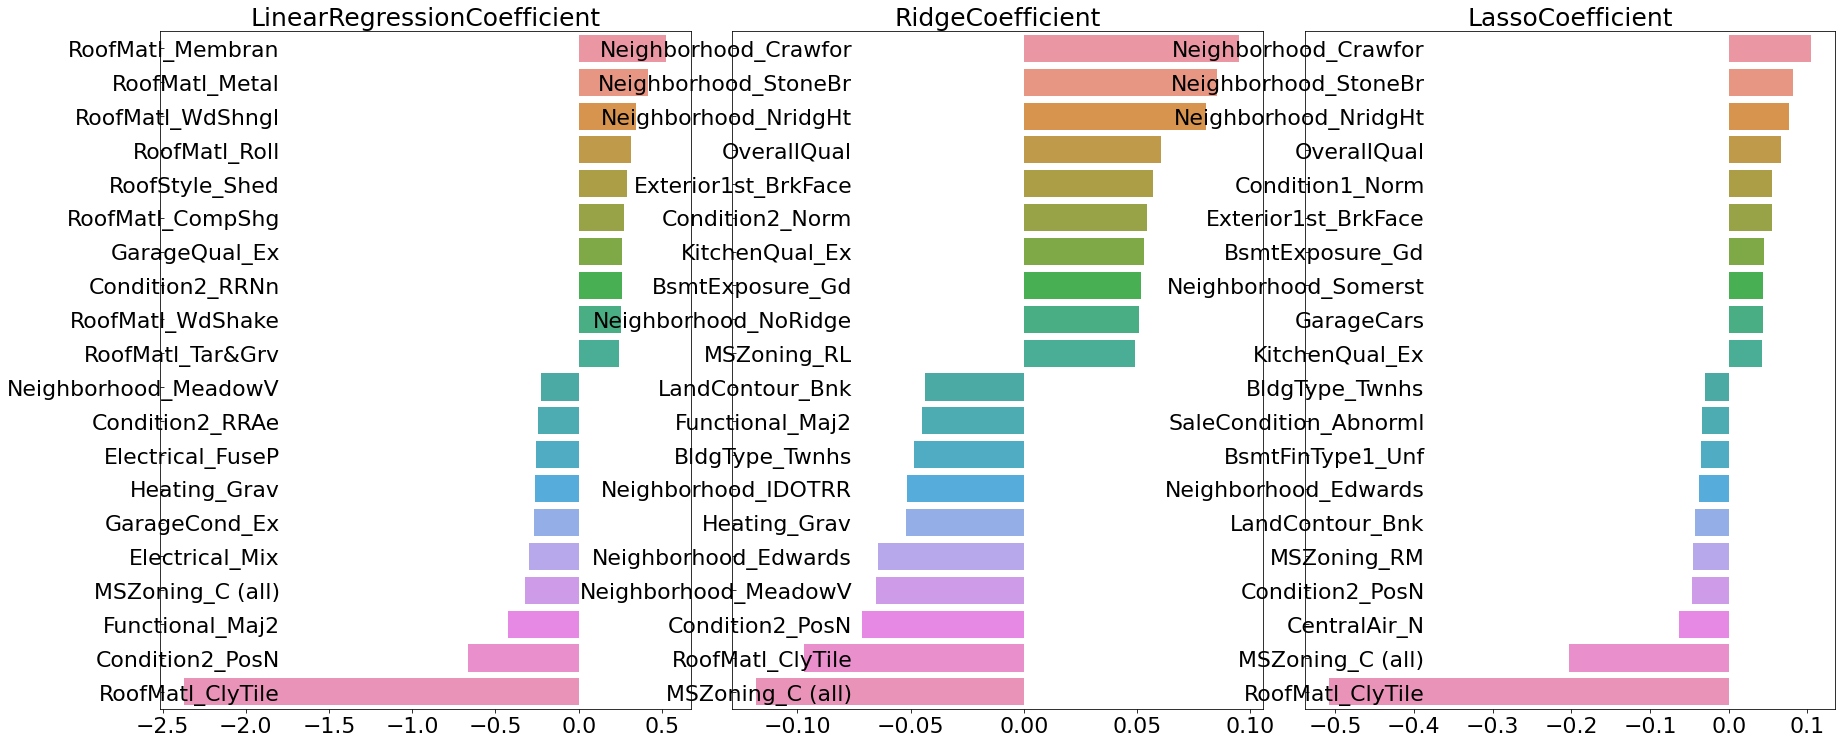

In [12]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가를 수행
lr_reg = LinearRegression()
lr_reg.fit(X_train,y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train,y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든모델의 RMSE출력
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 파라미터 튜닝이후 회귀계수에도 뚜렷한 변화가 나타남
- Ridge와 lasso는 비슷한 분포를 띄게 되었고 lasso의 계수가 여전히 작기는 하지만 전보다 균일해짐

#### 데이터 왜곡 로그변환 후 성능평가

- 피쳐 데이터 분포와 이상치를 해결한 후에 성능평가
- 데이터 분포의 왜도를 측정하기 위해 **skew()**함수 사용
- skew의 반환값이 **1이상이면 왜도가 높다고 판단**, 해당컬럼에 로그변환적용
- 함수적용시 원핫인코딩이 적용되지 않은 데이터프레임(house_df)이 적용되어야함

In [13]:
from scipy.stats import skew

# object가 아닌 숫자형 피쳐의 컬럼 index 객체를 추출
features_index = house_df.dtypes[house_df.dtypes != 'object'].index

# house_df에 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 셋 반환
# apply lambda로 skew호출
skew_features = house_df[features_index].apply(lambda x: skew(x))

# skew 정도가 1이상인 컬럼들만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending = False))

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [14]:
# 왜곡도가 높은 피쳐들 log변환 실시
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

- 로그변환 후 왜곡도가 많이 개선되었지만 그렇지 않은것도 존재

In [15]:
skew_features_log = house_df[features_index].apply(lambda x: skew(x))
skew_features_top_log = skew_features_log[skew_features_log > 1]
print(skew_features_top_log.sort_values(ascending = False))

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
dtype: float64


In [16]:
# Skew가 높은 피처들을 로그변환 했으므로 
# 다시 원-핫 인코딩 적용 및 피처/타겟 데이터셋 생성
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

# 피쳐들을 로그변환한 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1.5,10]}

best_ridge = print_best_params(ridge_reg,ridge_params)
best_lasso = print_best_params(lasso_reg,lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1252, 최적 alpha:{'alpha': 0.001}


- 하이퍼 파라미터와 RMSE모두 변했음을 볼 수 있음
- RMSE는 0.14에서 0.12로 향상되었음

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


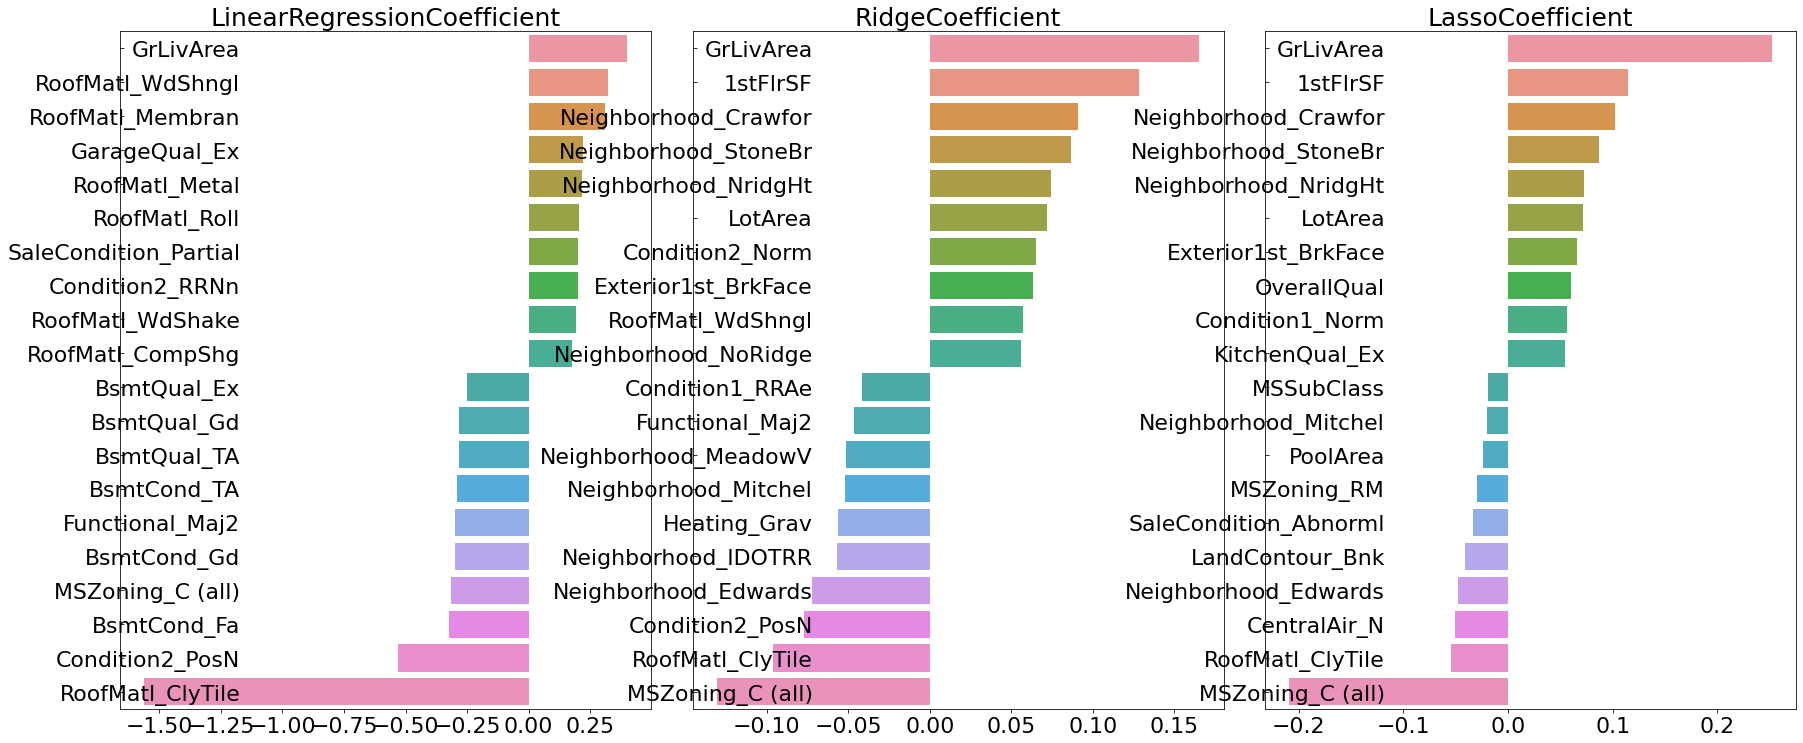

In [17]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 집값에 가장 영향을 주는 것이 주거공간의 크기가 되면서 상식선의 결과가 도출됨
- 왜곡도를 개선함으로써 성능 및 기대되는 결과가 나왔음을 보여줌

#### 이상치 제거

- **회귀계수에 많은 영향을 미치는** 피처의 이상치 처리가 중요
- 가장 중요한 변수였던 주거공간의 크기의 이상치를 찾아봄

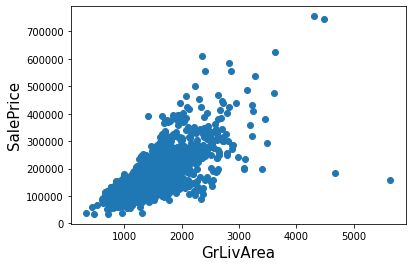

In [18]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org["SalePrice"])
plt.ylabel('SalePrice', fontsize = 15)
plt.xlabel('GrLivArea', fontsize = 15)
plt.show()

- 직관적으로 가격과 양의 상관관계가 있음을 알 수 있음
- 하지만 오른쪽 아래 2개의 점이 양의 상관관계가 아닌 이상치로 판단됨
- 이를 삭제하여 학습 진행

In [19]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index)
print('아웃라이어 삭제 전 house_df_ohe shape :', house_df_ohe.shape)

# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index, axis = 0, inplace = True)
print('아웃라이어 삭제 후 house_df_ohe shape :', house_df_ohe.shape)

아웃라이어 레코드 index : Int64Index([523, 1298], dtype='int64')
아웃라이어 삭제 전 house_df_ohe shape : (1460, 271)
아웃라이어 삭제 후 house_df_ohe shape : (1458, 271)


In [20]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size = 0.2, random_state = 156)

ridge_params = {'alpha':[0.05,0.1,1,5,8,10,12,15,20]}
lasso_params = {'alpha':[0.001,0.005,0.008,0.05,0.03,0.1,0.5,1.5,10]}

best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1122, 최적 alpha:{'alpha': 0.001}


- RMSE가 많이 개선되었음을 확인할 수 있고 ridge의 alpha값이 바뀌었음

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


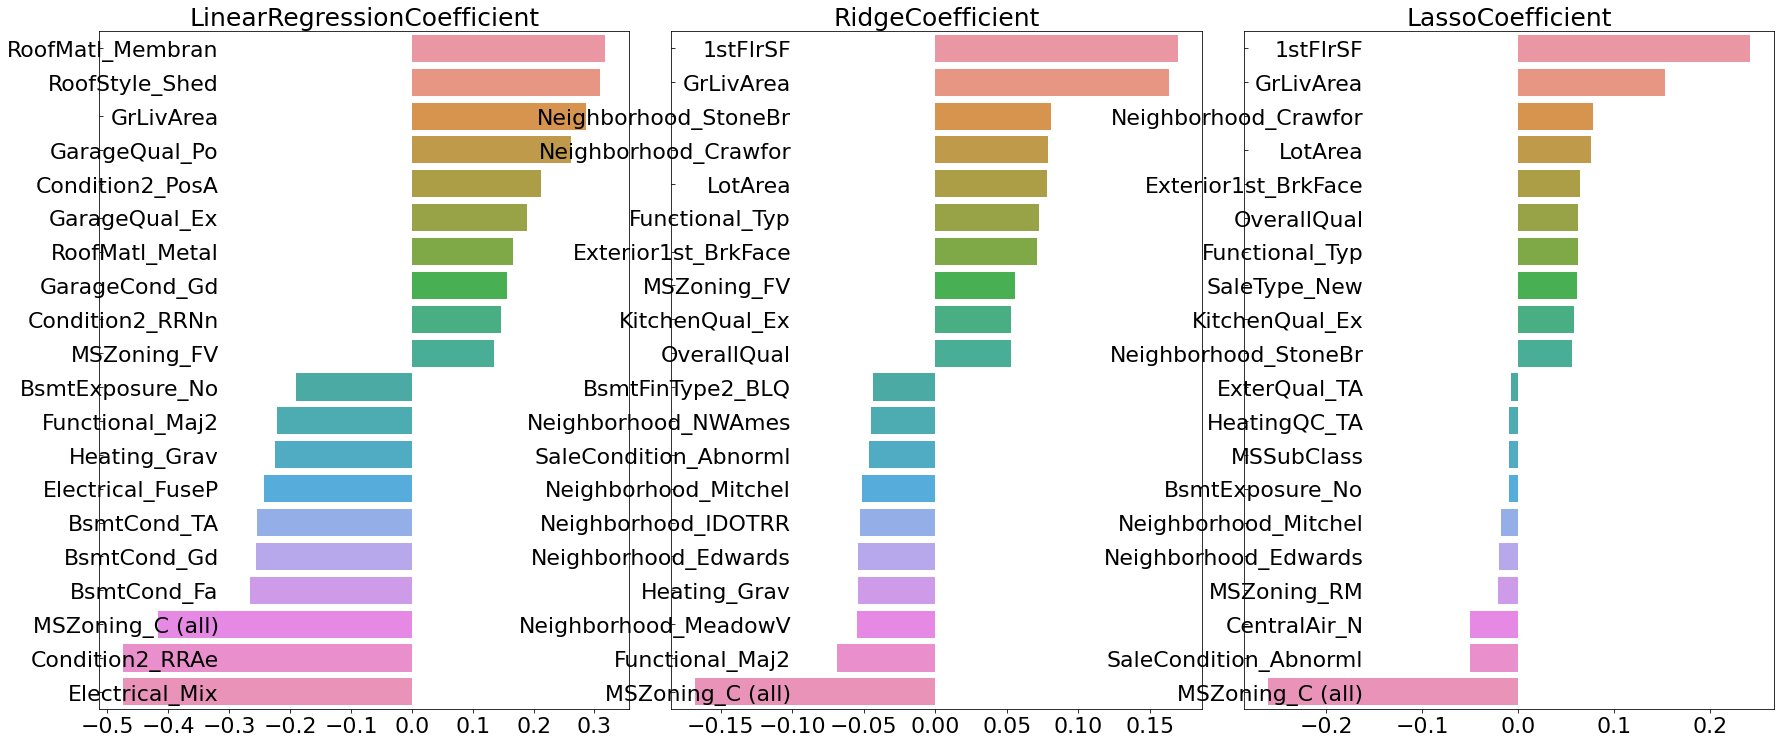

In [21]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행. 
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화 
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 결론
- 회귀의 중요한 영향을 미치는 피처 위주로 이상치 데이터를 찾으려고 노력해야함  
- 데이터가공 => 최적화를 **반복적으로 수행해줘야함** 
<span style="color:red">  </span>


### 회귀트리 모델 학습/예측/평가

#### XGBRegressor

In [24]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8, objective = 'reg:tweedie')
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.1147, 최적 alpha:{'n_estimators': 1000}


#### LGBMRegrssor

In [25]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1165, 최적 alpha:{'n_estimators': 1000}


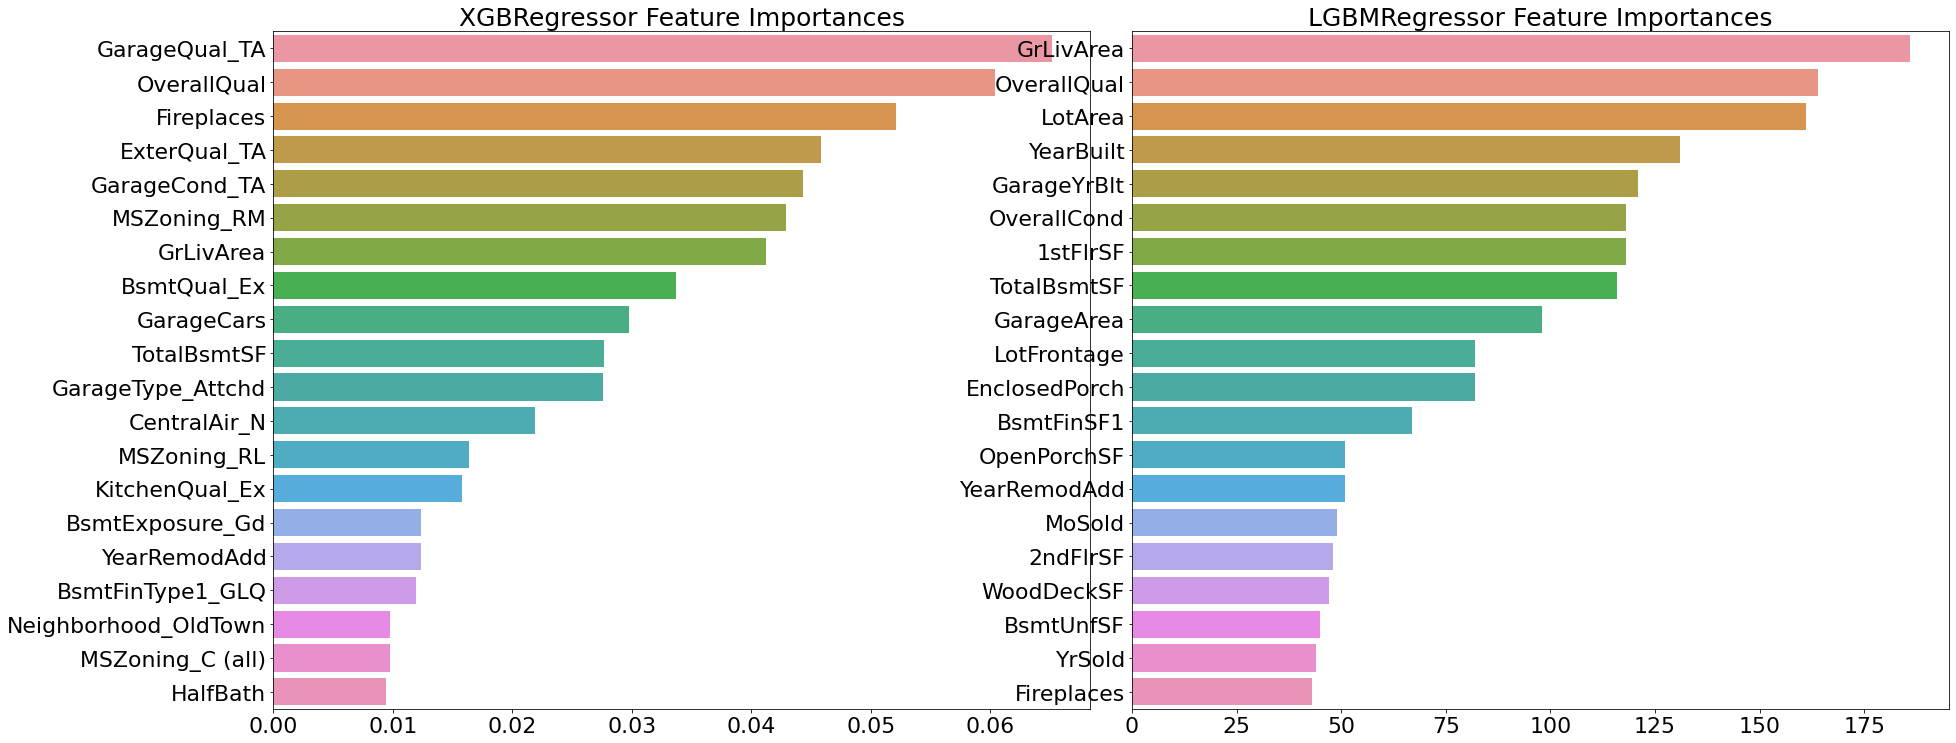

In [26]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)


### 회귀 모델들의 예측 결과 혼합을 통한 최종 예측

In [32]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.10007930884470519
Ridge 모델의 RMSE: 0.10345177546603272
Lasso 모델의 RMSE: 0.10024170460890039


In [33]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8, objective = 'reg:tweedie')
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.1019494521179687
XGBM 모델의 RMSE: 0.10856805444610668
LGBM 모델의 RMSE: 0.1015065721553885


### 스태킹 모델을 통한 회귀 예측

In [34]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [35]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)



Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [36]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)



스태킹 회귀 모델의 최종 RMSE 값은: 0.09778644019699911
